## DATA IMPORTING

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import math

In [2]:
df1 = pd.read_csv('train.csv').dropna() #Training Dataset
df2 = pd.read_csv('test.csv') #Testing dataset
codf = pd.read_csv('US_COVID_data_state_level.csv') #Covid data of cities
cidf = pd.read_csv('city_details.csv') #Cities data
wadf = pd.read_csv('warehouse_mapping.csv')
co = pd.read_csv('United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')
holiday_df = pd.read_csv("US Holiday Dates (2004-2021).csv")

In [3]:
df1['date']=pd.to_datetime(df1.date)
co.rename(columns={'submission_date':'date'},inplace=True)
co['date']=pd.to_datetime(co.date)
df1.sort_values('date',inplace = True)
df1.index = np.arange(df1.shape[0])
codf['date']=pd.to_datetime(codf.date)
codf.sort_values('date',inplace = True)
codf.index = np.arange(codf.shape[0])

## Predicting Confirmed Cases

In [4]:
corl = codf[codf.conf_cases.notna()] #Non-empty cells of confirmed cases

In [5]:
a,b = np.array(list(corl.tot_cases)),np.array(list(corl.conf_cases))

In [7]:
pd.Series(a).corr(pd.Series(b))

0.994857188030104

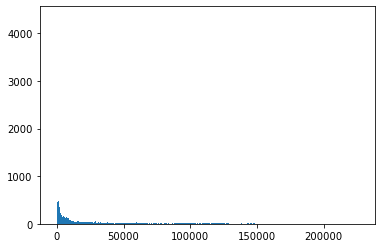

In [38]:
plt.hist(a-b,bins=500);

In [20]:
conf = pd.DataFrame({'tot':a,'conf':b})

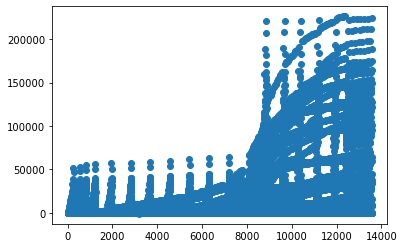

In [24]:
plt.scatter(x=np.arange(1,a.shape[0]+1),y=conf.tot - conf.conf)

In [8]:
from sklearn.ensemble import RandomForestRegressor 
# algo=RandomForestRegressor()
# ratio = []
# for i in range(len(a)):
#     if b[i]!=0:
#         ratio.append((a[i]-b[i])/(b[i]))
#     else:
#         ratio.append(0)
# a=np.array(a).reshape(-1,1)
# algo.fit(a,ratio)
# for i in codf[codf.conf_cases.isna()].index:
#     codf.iloc[i,3] = int(np.array(codf.iloc[i,2])/(1+algo.predict(np.array(codf.iloc[i,2].reshape(1,-1)))))
algo=RandomForestRegressor()
algo.fit(a.reshape(-1,1),b)

In [9]:
codf.head(5)

,date,state,tot_cases,conf_cases
0,2020-01-02,PA,0,NaN
1,2020-01-02,DE,0,NaN
2,2020-01-02,NJ,0,NaN
3,2020-01-02,RI,0,NaN
4,2020-01-02,VI,0,NaN


In [10]:
for i in codf[codf.conf_cases.isna()].index:
     codf.iloc[i,3] = int(algo.predict(np.array(codf.iloc[i,2].reshape(1,-1))))

In [11]:
codf.sample(5)

,date,state,tot_cases,conf_cases
12561,2020-08-14,AS,0,0.0
9874,2020-06-28,KS,13538,13227.0
5914,2020-04-21,PA,34528,33923.0
3231,2020-03-06,ID,2990,2709.0
18343,2020-11-21,OH,343286,325611.0


In [12]:
codf.isna().sum()

date          0
state         0
tot_cases     0
conf_cases    0
dtype: int64

## DATA CLEANING

In [4]:
cidf1 = cidf.drop(['country'],axis = 1) #dropping useless columns
cidf1 = cidf1.drop_duplicates()
cidf1.tail(),cidf1.shape

(            city  zip_code state  state_name
 554  WESTMINSTER     92683    CA  CALIFORNIA
 555      ONTARIO     91761    CA  CALIFORNIA
 556       TACOMA     98409    WA  WASHINGTON
 557      BOZEMAN     59718    MT     MONTANA
 558    CLACKAMAS     97015    OR      OREGON,
 (555, 4))

In [5]:
value,counts = np.unique(cidf1.zip_code,return_counts=True)
value[counts>1],counts[counts>1]

(array([94080, 98027], dtype=int64), array([2, 2], dtype=int64))

In [6]:
cidf1[cidf1.zip_code == 94080]

,city,zip_code,state,state_name
370,S,94080,CA,CALIFORNIA
371,EL,94080,CA,CALIFORNIA


In [7]:
cidf1.drop(index=371,inplace=True)

In [8]:
cidf1[cidf1.zip_code == 98027]

,city,zip_code,state,state_name
69,ISSAQUAH,98027,WA,WASHINGTON
70,US,98027,WA,WASHINGTON


In [9]:
cidf1.drop(index=70,inplace=True)

In [10]:
uszips = pd.read_csv('uszips.csv')
# zips = uszips.zip.unique()
# sum =0
# for z in y:
#     if z in zips:
#         sum+=1
#     else: print(z)
# sum,y.shape
cidf1 = cidf1.merge(uszips[['zip','population']],how='left',right_on='zip',left_on='zip_code')

In [11]:
cidf1[cidf1.population.isna()]

,city,zip_code,state,state_name,zip,population
67,FRISCO,75033,TX,TEXAS,75033,NaN


In [12]:
state = cidf1.state.unique()
num_cities = [cidf1[cidf1.state == st].zip_code.nunique() for st in state]
tot_population_state = [cidf1[cidf1.state==st].population.sum() for st in state]
stct = pd.DataFrame({'state':state,'num_cities':num_cities})
stpop = pd.DataFrame({'state':state,'tot_population_state':tot_population_state})

## DATA PREPROCESSING

In [13]:
cidf_final = cidf1.merge(stct,on = 'state',how = 'left').merge(stpop,on='state',how='left');

In [14]:
wadf.sample(5)

,wh_id,warehouse_name
413,485,WAREHOUSE 485 WAIPIO
527,769,WAREHOUSE 769 INGLEWOOD
6,1003,WAREHOUSE 1003 WOODLAND
92,1126,WAREHOUSE 1126 EAST PEORIA
514,745,WAREHOUSE 745 KALISPELL


In [15]:
m = co.sort_values('date')[['date','state','tot_cases','conf_cases','tot_death']].merge(cidf_final,how = 'left',on='state') 
print(m.shape)
m['avg_tot_cases/num_cities'] = m['tot_cases'].div(m['num_cities'], fill_value=10)
m['avg_conf_cases/num_cities'] = m['conf_cases'].div(m['num_cities'], fill_value=10)
m['avg_tot_cases/city_weight'] = m['tot_cases']*m['population']/m['tot_population_state']
m['avg_conf_cases/city_weight'] = m['conf_cases']*m['population']/m['tot_population_state']
m['avg_tot_death/num_cities'] = m['tot_death'].div(m['num_cities'], fill_value=10)
m['avg_tot_death/city_weight'] = m['tot_death']*m['population']/m['tot_population_state']
m.sample(5) #merging covid data and cities data using state as a common entity

(562038, 12)


,date,state,tot_cases,conf_cases,tot_death,city,zip_code,state_name,zip,population,num_cities,tot_population_state,avg_tot_cases/num_cities,avg_conf_cases/num_cities,avg_tot_cases/city_weight,avg_conf_cases/city_weight,avg_tot_death/num_cities,avg_tot_death/city_weight
341554,2021-09-16,CA,4588021,4387926.0,67187,NOVATO,94945.0,CALIFORNIA,94945.0,18084.0,126.0,5739662.0,36412.865079,34824.809524,14455.515284,13825.074331,533.230159,211.686630
237976,2021-03-17,NY,973707,NaN,18477,LAWRENCE,11559.0,NEW YORK,11559.0,8265.0,19.0,586641.0,51247.736842,0.526316,13718.250779,NaN,972.473684,260.316625
419220,2022-01-31,GA,2368052,1842500.0,32976,TOWN,30144.0,GEORGIA,30144.0,59085.0,14.0,672164.0,169146.571429,131607.142857,208158.057290,161960.641302,2355.428571,2898.677942
49177,2020-04-17,IL,27575,NaN,1134,ORLAND,60467.0,ILLINOIS,60467.0,26056.0,22.0,820703.0,1253.409091,0.454545,875.461891,NaN,51.545455,36.002676
186212,2020-12-15,NE,150496,NaN,1438,LA,68128.0,NEBRASKA,68128.0,19204.0,3.0,55762.0,50165.333333,3.333333,51829.654317,NaN,479.333333,495.236039


In [16]:
b = []
for row in wadf.values:
  b.append(row[1].split()[2]) #taking 3rd word from warehouse_name which is city

wadf['city'] = np.array(b)
wadf.sample(5)

,wh_id,warehouse_name,city
490,683,WAREHOUSE 683 LEWISVILLE,LEWISVILLE
453,643,WAREHOUSE 643 SW BAKERSFIELD,SW
481,675,WAREHOUSE 675 WILLOWBROOK,WILLOWBROOK
116,1178,WAREHOUSE 1178 TIMNATH,TIMNATH
438,63,WAREHOUSE 63 NE ANCHORAGE,NE


In [17]:
value,counts = np.unique(wadf.city,return_counts=True)
value[counts>1],counts[counts>1]

(array(['AURORA', 'AVON', 'BURBANK', 'COLUMBIA', 'COMMERCE', 'CYPRESS',
        'DALLAS', 'E', 'EAST', 'EL', 'EVERETT', 'FORT', 'GRAND',
        'HAWTHORNE', 'HAYWARD', 'LA', 'LAGUNA', 'LAKE', 'LANCASTER',
        'LINCOLN', 'LYNNWOOD', 'MIAMI', 'MT', 'N', 'NE', 'NEW', 'NORTH',
        'NORWALK', 'NW', 'PALM', 'RANCHO', 'ROCHESTER', 'ROSEVILLE', 'S',
        'SACRAMENTO', 'SAN', 'SANTA', 'SE', 'SOUTH', 'ST', 'SW', 'TUSTIN',
        'UNION', 'W', 'WEST', 'WESTMINSTER', 'WOODLAND'], dtype=object),
 array([ 2,  2,  2,  2,  2,  2,  3,  7,  3,  3,  2,  4,  2,  2,  2,  4,  2,
         3,  2,  2,  2,  2,  4,  6,  4,  4,  3,  2,  4,  2,  3,  2,  2,  6,
         2, 10,  5,  4,  2,  5,  4,  2,  2,  8,  4,  2,  2], dtype=int64))

In [18]:
x = df1.merge(wadf.drop(axis = 1,columns=['warehouse_name']),how='left',on = 'wh_id')

In [19]:
print(x.shape)
x.sample(5)
# merged data of train and warehouse datasets

(449995, 4)


,date,wh_id,sales,city
367563,2020-10-20,203.0,355,GLEN
310259,2020-07-10,116.0,84,ALBUQUERQUE
51877,2019-04-04,465.0,12,THOMAS
425611,2021-02-19,674.0,609,GLENDALE
264872,2020-04-19,130.0,11,LOS


In [20]:
z = x.merge(m,how='left', on = ['date','city'])

In [21]:
print(z.shape)
z.sample(5)

(646135, 20)


,date,wh_id,sales,city,state,tot_cases,conf_cases,tot_death,zip_code,state_name,zip,population,num_cities,tot_population_state,avg_tot_cases/num_cities,avg_conf_cases/num_cities,avg_tot_cases/city_weight,avg_conf_cases/city_weight,avg_tot_death/num_cities,avg_tot_death/city_weight
524138,2020-11-18,443.0,854,SW,CA,1047789.0,1047789.0,18395.0,93313.0,CALIFORNIA,93313.0,57200.0,126.0,5739662.0,8315.785714,8315.785714,10441.996550,10441.996550,145.992063,183.319854
264482,2020-03-10,630.0,849,W,TX,15.0,NaN,0.0,77494.0,TEXAS,77494.0,126310.0,33.0,1602967.0,0.454545,0.303030,1.181964,NaN,0.000000,0.000000
507319,2020-11-01,780.0,72,ENFIELD,CT,71207.0,67519.0,4616.0,6082.0,CONNECTICUT,6082.0,43952.0,7.0,196324.0,10172.428571,9645.571429,15941.454249,15115.803916,659.428571,1033.406165
337852,2020-05-20,464.0,33,SACRAMENTO,CA,84057.0,84057.0,3374.0,95823.0,CALIFORNIA,95823.0,80842.0,126.0,5739662.0,667.119048,667.119048,1183.926160,1183.926160,26.777778,47.522120
96660,2019-06-23,479.0,28,CULVER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
#precovid data
precov = z[z.state.isna()][['date','wh_id','sales','tot_cases','avg_tot_cases/num_cities','avg_tot_cases/city_weight','tot_death',
                            'avg_tot_death/num_cities','avg_tot_death/city_weight']].fillna(0)
cov = z[z.state.notna()][['date','wh_id','sales','tot_cases','avg_tot_cases/num_cities','avg_tot_cases/city_weight','tot_death',
                          'avg_tot_death/num_cities','avg_tot_death/city_weight']]
precov.sort_values(['date','wh_id'],ignore_index=True,inplace = True)
cov.sort_values(['date','wh_id'],ignore_index=True,inplace = True)

## EDA

In [23]:
# Import libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Configuring styles
sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (25, 10)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [24]:
def week_avg_wh_id(wh_id):
    week_avg = []
    start = 0
    shape = df1[df1.wh_id == wh_id].shape[0]
    while start<shape:
        week_avg.append(df1[df1.wh_id == wh_id][start:start+7].sales.mean())
        start += 7
    return week_avg

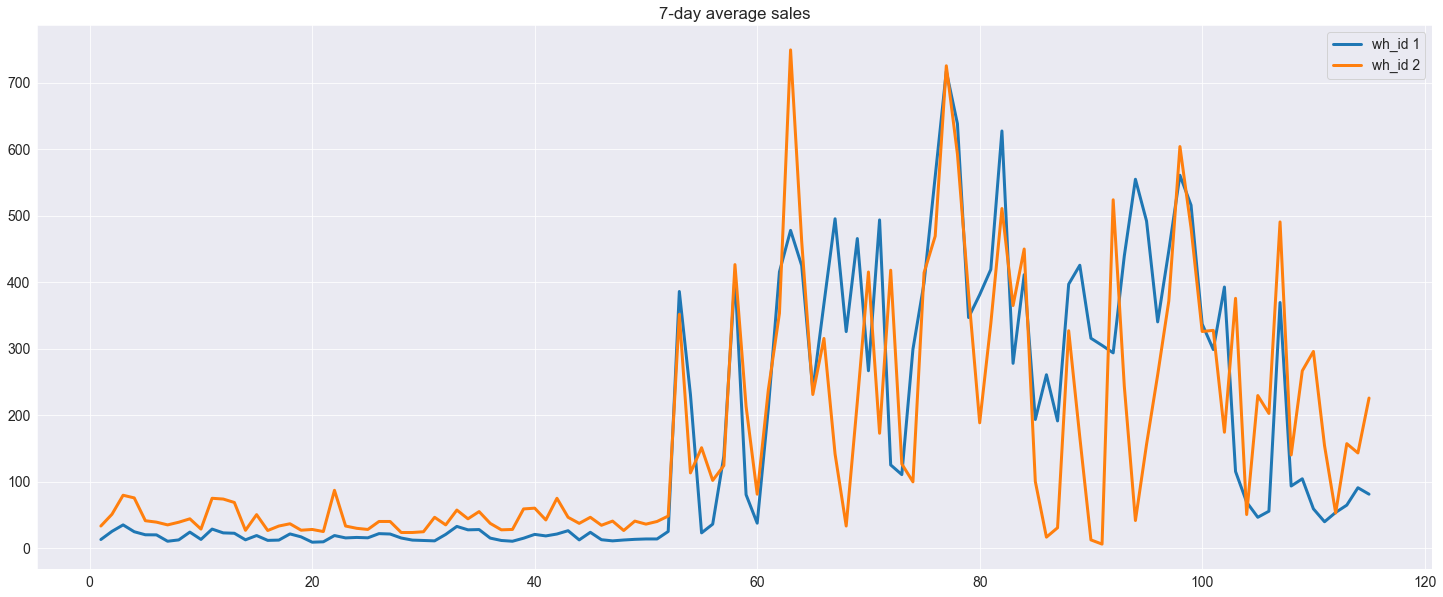

In [25]:
legend = []
for i in range(1,3):
    y = week_avg_wh_id(df1.wh_id.unique()[i])
    plt.plot(range(1,len(y)+1),y,linewidth = 3)
    legend.append('wh_id ' + str(i))
plt.legend(legend);
plt.title('7-day average sales');

In [36]:
codf.groupby('date').sum().tot_cases

date
2020-01-02          84
2020-01-03         742
2020-01-04      243463
2020-01-05     1128248
2020-01-06     1874225
                ...   
2021-12-01    23182880
2021-12-02    27589261
2021-12-03    29296042
2021-12-04    31167182
2021-12-05    32665712
Name: tot_cases, Length: 488, dtype: int64

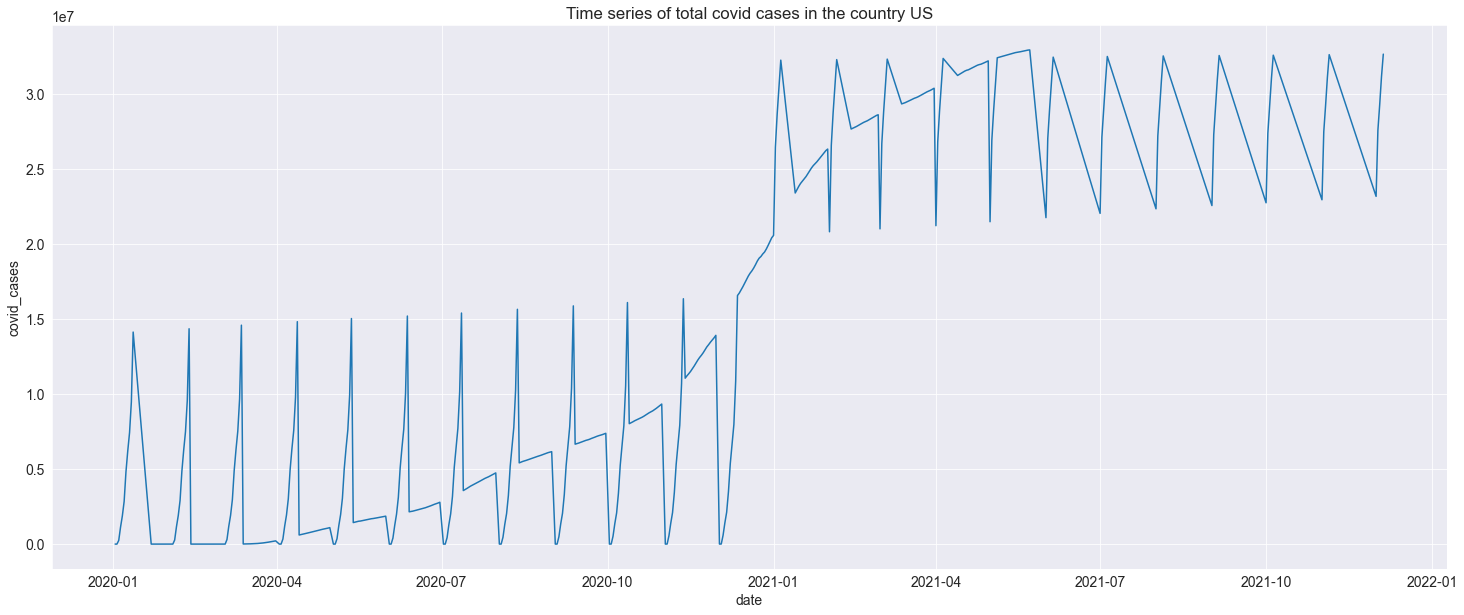

In [38]:
plt.plot(codf.date.unique(),codf.groupby('date').sum().tot_cases)
plt.title('Time series of total covid cases in the country US')
plt.xlabel('date')
plt.ylabel('covid_cases');

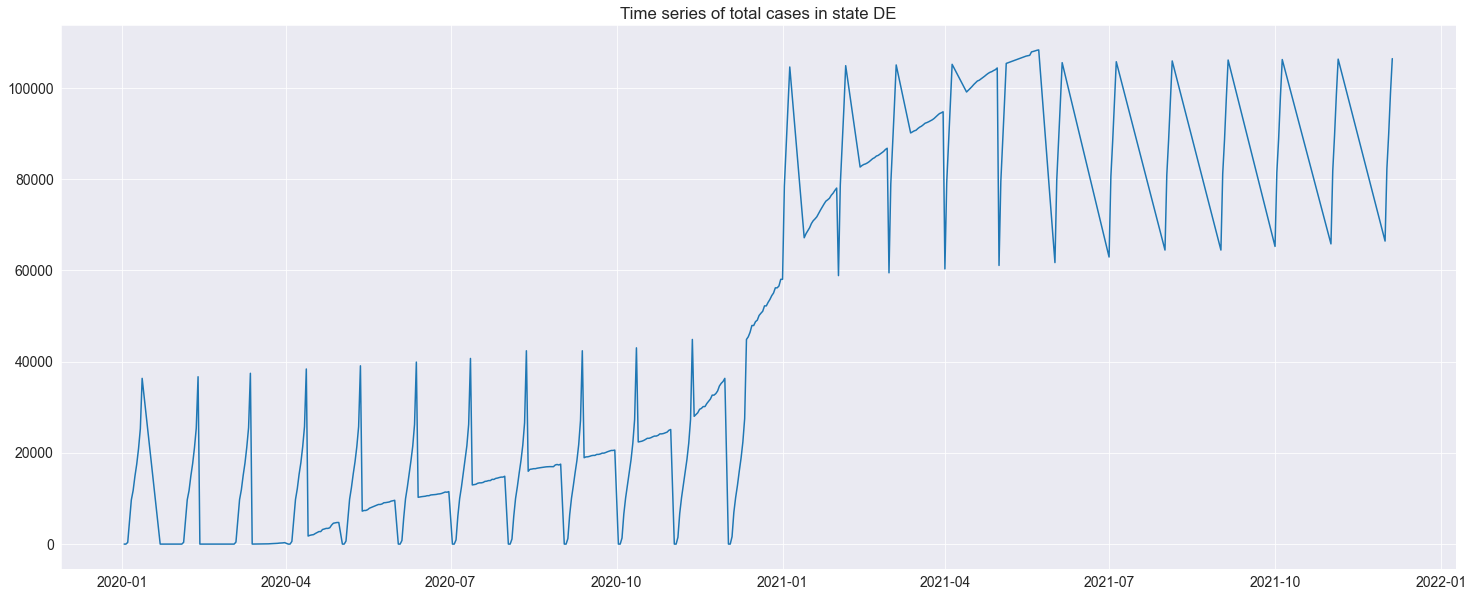

In [39]:
def cov_cases_state(state):
    plt.plot(codf[codf.state==state].date,codf[codf.state==state].tot_cases)
    plt.title('Time series of total cases in state '+state)
cov_cases_state('DE')

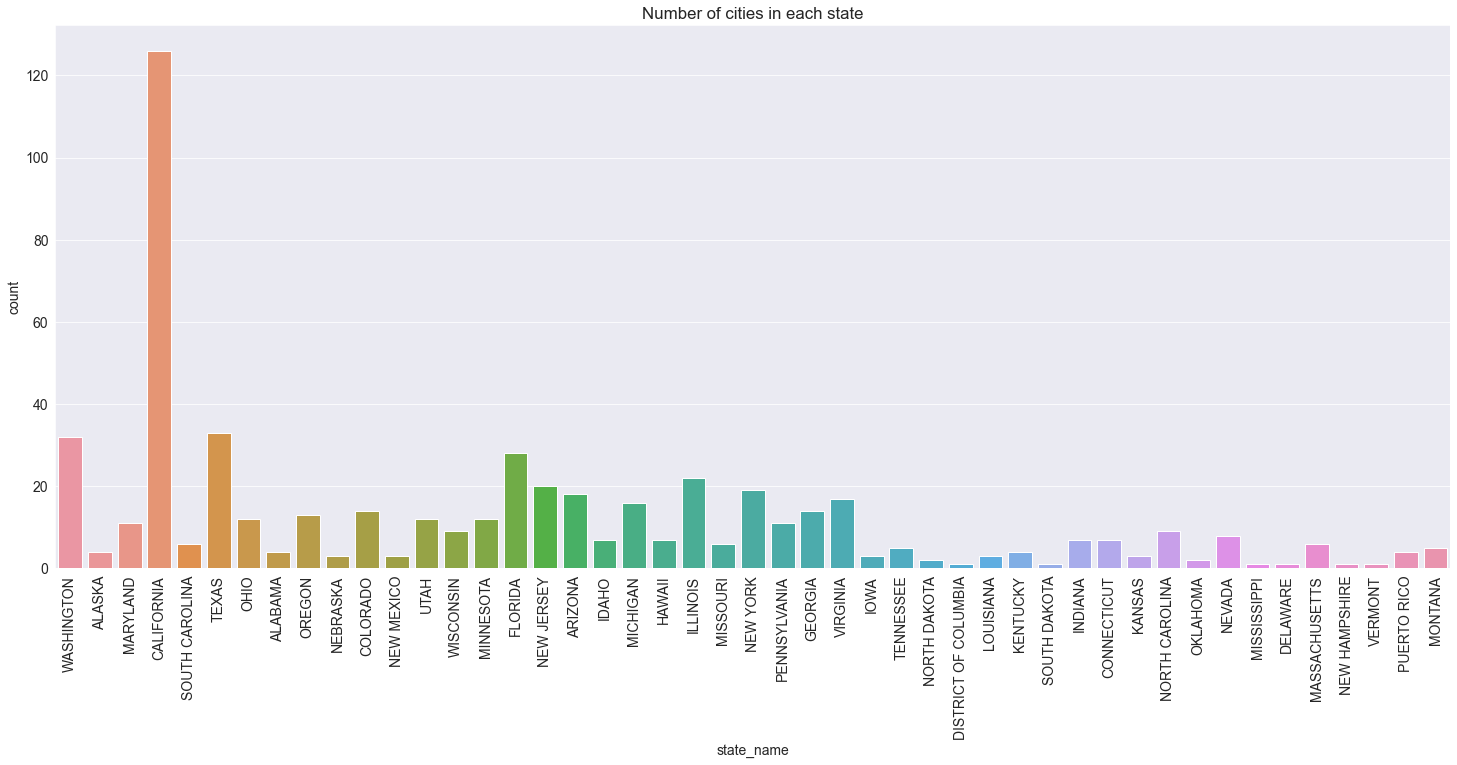

In [41]:
# State vs No.of cities
fig=sns.countplot(x=cidf_final.state_name);
plt.xticks(rotation=90);
plt.title('Number of cities in each state')
plt.show();

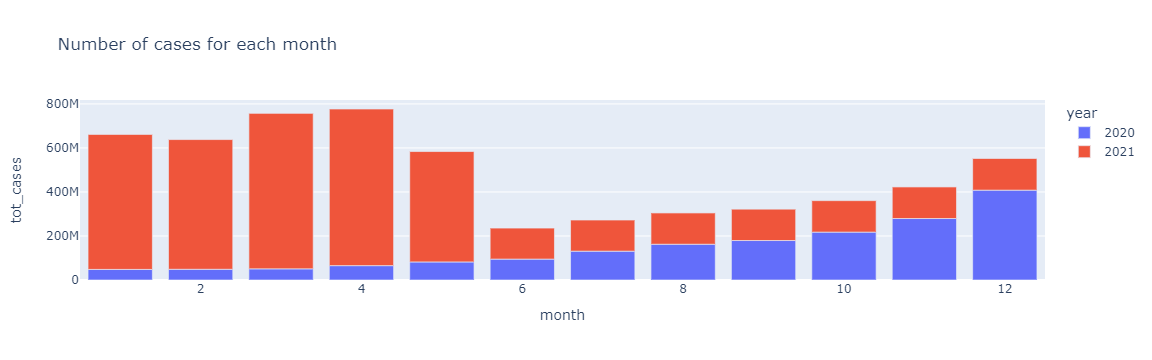

In [45]:
codf['month'] = codf.date.dt.month
cov_eda_2020 = codf[codf.date.dt.year == 2020].groupby('month').sum()
cov_eda_2020['year'],cov_eda_2020['month'] = '2020',cov_eda_2020.index
cov_eda_2021 = codf[codf.date.dt.year == 2021].groupby('month').sum()
cov_eda_2021['year'],cov_eda_2021['month'] ='2021',cov_eda_2021.index
cov_eda = pd.concat([cov_eda_2020,cov_eda_2021])
px.bar(cov_eda,x='month',y='tot_cases',color = 'year',title='Number of cases for each month')

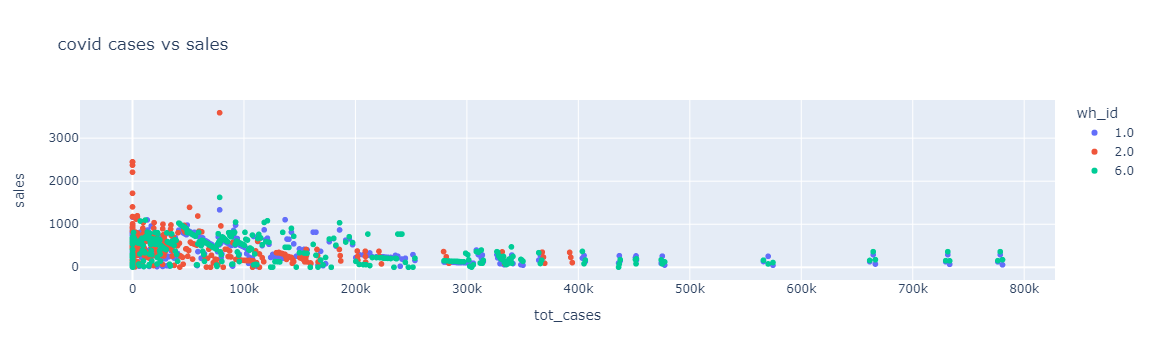

In [66]:
cov['wh_id']=cov['wh_id'].astype('object')
fig = px.scatter(cov[(cov.wh_id==1)|(cov.wh_id==2)|(cov.wh_id==6)], x="tot_cases", y="sales",
                 title='covid cases vs sales',color='wh_id')
fig.show()

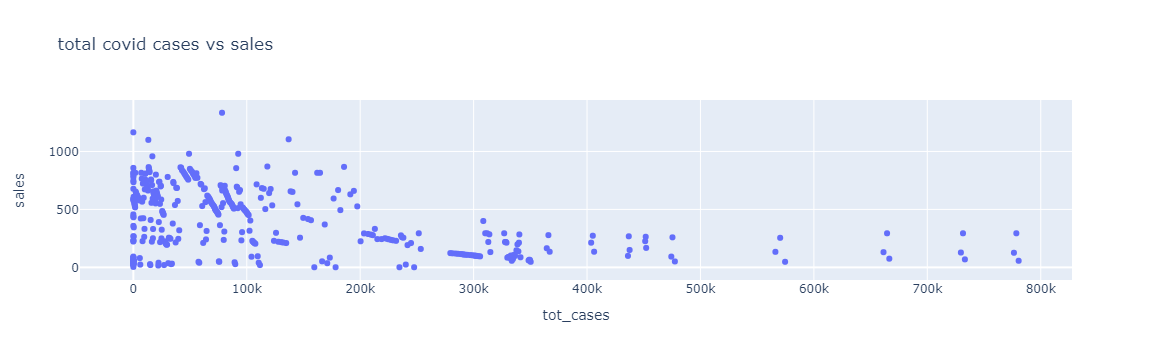

In [63]:
cov['wh_id']=cov['wh_id'].astype('object')
fig = px.scatter(cov[cov.wh_id==1], x="tot_cases", y="sales",
                 title='total covid cases vs sales')
fig.show()

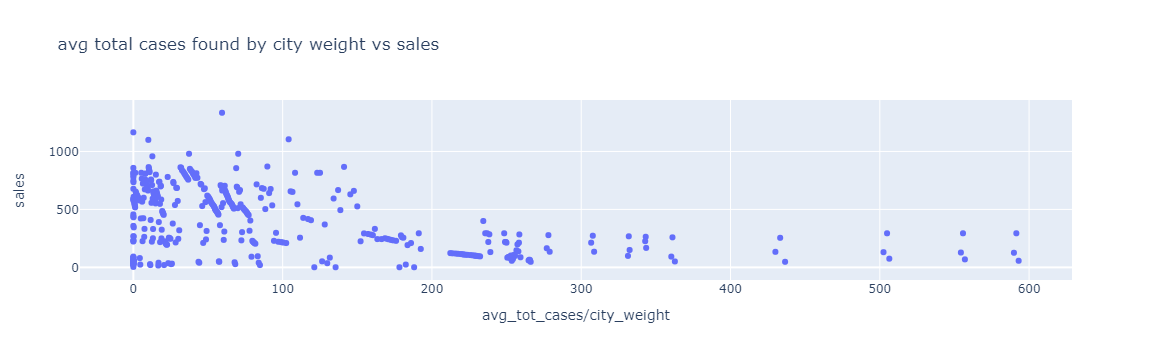

In [62]:
px.scatter(cov[cov.wh_id==1], x="avg_tot_cases/city_weight", y="sales",
                 title='avg total cases found by city weight vs sales')

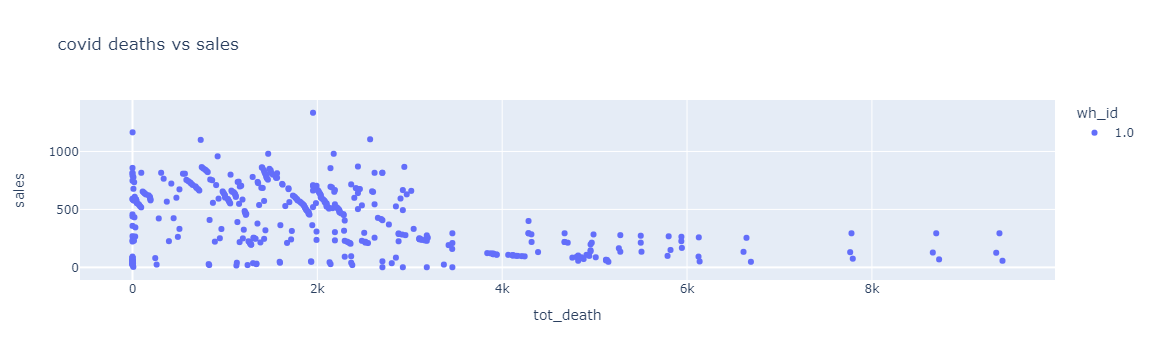

In [61]:
px.scatter(cov[cov.wh_id==1], x="tot_death", y="sales",
                 title='covid deaths vs sales',color='wh_id')

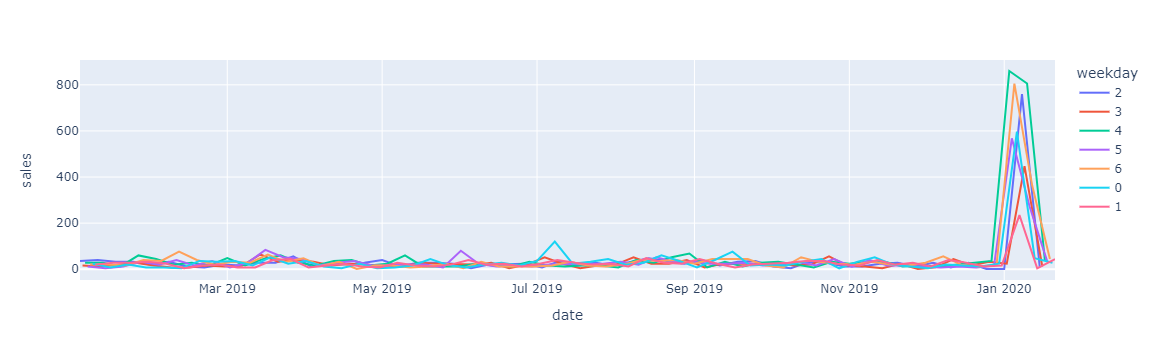

In [32]:
precov_eda = precov[precov.wh_id == 1][['date','sales']]
precov_eda.loc[:,'weekday']=precov.date.dt.weekday.astype('object')
px.line(precov_eda,x='date',y='sales',color='weekday')

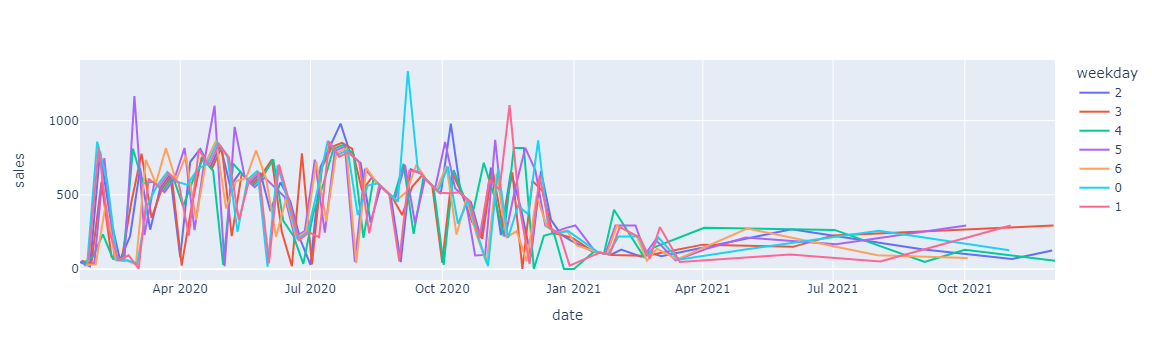

In [33]:
cov_eda = cov[cov.wh_id == 1][['date','sales']]
cov_eda.loc[:,'weekday']=cov.date.dt.weekday.astype('object')
px.line(cov_eda,x='date',y='sales',color='weekday')

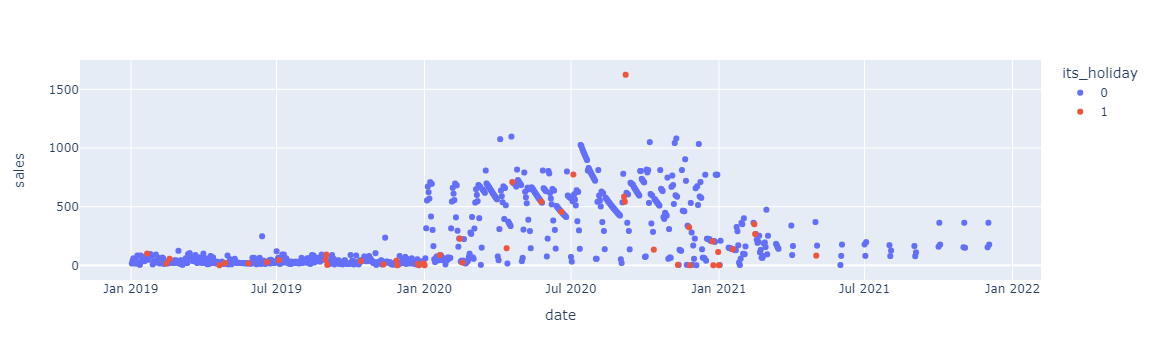

In [34]:
holiday_df.Date = pd.to_datetime(holiday_df.Date)
holiday_df['its_holiday'] = ['1']*holiday_df.shape[0]
hol_eda = z.merge(holiday_df[['Date','its_holiday']],right_on='Date',left_on='date',how='left')
hol_eda.fillna('0',inplace=True)
hol_eda = hol_eda[hol_eda.wh_id == 6][['date','sales','its_holiday']]
px.scatter(hol_eda,x='date',y='sales',color='its_holiday')

## DATA SPLITTING

In [129]:
import torch
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.utils.data as utils
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
import torch.nn as nn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,LeakyReLU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

In [ ]:
X1=cov[['date','wh_id','avg_tot_cases/city_weight','sales']]
X1=X1.fillna(0)
X1

In [ ]:
c=X1.groupby('wh_id')
wh=[i for i in c]
wh2=wh[1][1]
wh2.reset_index(inplace=True,drop=True)

In [ ]:
dataset=wh2[['sales','avg_tot_cases/city_weight']].values

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
train_size = int(len(dataset) * 0.92)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

In [ ]:
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [ ]:
trainY=trainY.reshape(-1,1)

## Training

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]),return_sequences=True))
model.add(LeakyReLU(alpha=0.5))
model.add(LSTM(64,return_sequences=True))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.2))
model.add(LSTM(32,return_sequences=False))
model.add(Dense(trainY.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX,trainY, epochs=100, batch_size=1)

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
trainPredict = scaler.inverse_transform(np.repeat(trainPredict.reshape(-1,1),trainX.shape[2],axis=1))[:,0]
trainY = scaler.inverse_transform(np.repeat(trainY,trainX.shape[2],axis=1))[:,0]

In [ ]:
concat=np.concatenate((trainPredict.reshape(-1,1),trainY.reshape(-1,1)),axis=1)

In [ ]:
actual_value=trainY
predicted_value=trainPredict
score=100*((np.abs(actual_value-predicted_value).sum())/np.abs(actual_value).sum())
score

In [ ]:
testPredict = scaler.inverse_transform(np.repeat(testPredict.reshape(-1,1),trainX.shape[2],axis=1))[:,0]
testY = scaler.inverse_transform(np.repeat(testY.reshape(-1,1),trainX.shape[2],axis=1))[:,0]

In [ ]:
actual_values=testY
predicted_values=testPredict
score=100*((np.abs(actual_values-predicted_values).sum())/np.abs(actual_values).sum())
score

In [ ]:
np.concatenate((testPredict.reshape(-1,1),testY.reshape(-1,1)),axis=1)